# Let's predict MI's stock price

We will use Pandas, scikit learn and matplotlib to predict and display MI stock price

<img src="http://pandas.pydata.org/_static/pandas_logo.png",width=240,height=240><img src="https://matplotlib.org/_static/logo2.svg",width=240,height=240><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png",width=240,height=240>


## About Scikit-Learn

[Scikit-Learn](http://github.com/scikit-learn/scikit-learn) is a Python package designed to give access to **well-known** machine learning algorithms within Python code, through a **clean, well-thought-out API**. It has been built by hundreds of contributors from around the world, and is used across industry and academia.

Scikit-Learn is built upon Python's [NumPy (Numerical Python)](http://numpy.org) and [SciPy (Scientific Python)](http://scipy.org) libraries, which enable efficient in-core numerical and scientific computation within Python. As such, scikit-learn is not specifically designed for extremely large datasets, though there is [some work](https://github.com/ogrisel/parallel_ml_tutorial) in this area.

For this short introduction, I'm going to stick to questions of in-core processing of small to medium datasets with Scikit-learn.

(0, 12)

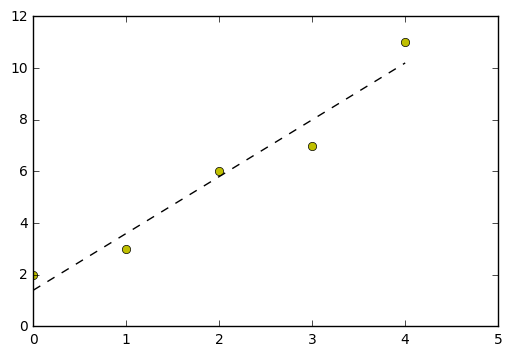

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = np.random.randint(120, size=10)
y = np.random.randint(200, size=10)

x = [0,1,2,3,4]
y = [2,3,6,7,11] # 10, not 9, so the fit isn't perfect

fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

plt.plot(x,y, 'yo', x, fit_fn(x), '--k')
plt.xlim(0, 5)
plt.ylim(0, 12)

Again, this is an example of fitting a model to data, such that the model can make
generalizations about new data.  The model has been **learned** from the training
data, and can be used to predict the result of test data:
here, we might be given an x-value, and the model would
allow us to predict the y value.  Again, this might seem like a trivial problem,
but it is a basic example of a type of operation that is fundamental to
machine learning tasks.

## Let's gather Data first .....

In [3]:
from pandas_datareader import data
from datetime import datetime, timedelta
from matplotlib import style
style.use('ggplot')

In [5]:
start_date = datetime(2014, 6, 12)
end_date = datetime.today()
ticker = 'MOBL'
source = 'google'
mobl_df = data.DataReader(ticker, source, start_date, end_date)

In [6]:
mobl_df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2017-08-24,3.85,3.95,3.80,3.90,1061225
2017-08-25,3.90,3.95,3.72,3.80,406296
2017-08-28,3.80,3.80,3.68,3.75,322930
2017-08-29,3.70,3.90,3.70,3.85,203553
2017-08-30,3.80,3.92,3.80,3.80,340763


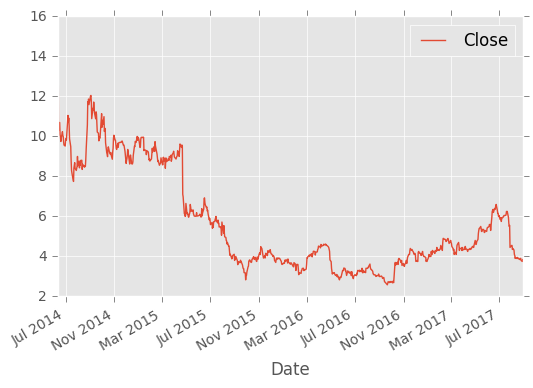

In [7]:
%matplotlib inline
mobl_df.plot(y='Close')

In [8]:
# save the date in a file, we do not want to call this api again and again
mobl_df.to_csv('mobl.csv')

In [9]:
import numpy as np 
import pandas as pd 
from sklearn import cross_validation,preprocessing
from sklearn.linear_model import LinearRegression
import math
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
forecast_length = int(math.ceil(0.02 * len(mobl_df)))
print('forecast leanght is : ' + str(forecast_length))

forecast leanght is : 17


In [11]:
df=pd.read_csv('mobl.csv')

In [12]:
df['Date'] = df['Date'].astype('datetime64[ns]')
df.set_index('Date',inplace='True')
df['High_Low_Change']=(df['High']-df['Close'])/df['Close']*100.0
df['Change_Perc']=(df['Close']-df['Open'])/df['Open']*100.0
    
df=df[['Close','High_Low_Change','Change_Perc','Volume']]
df.fillna(-9999,inplace='True')

In [13]:
df.tail()

,Close,High_Low_Change,Change_Perc,Volume
Date,,,,
2017-08-24,3.90,1.282051,1.298701,1061225
2017-08-25,3.80,3.947368,-2.564103,406296
2017-08-28,3.75,1.333333,-1.315789,322930
2017-08-29,3.85,1.298701,4.054054,203553
2017-08-30,3.80,3.157895,0.000000,340763


In [14]:
df['Prediction']=df['Close'].shift(-forecast_length)
df.tail()

,Close,High_Low_Change,Change_Perc,Volume,Prediction
Date,,,,,
2017-08-24,3.90,1.282051,1.298701,1061225,NaN
2017-08-25,3.80,3.947368,-2.564103,406296,NaN
2017-08-28,3.75,1.333333,-1.315789,322930,NaN
2017-08-29,3.85,1.298701,4.054054,203553,NaN
2017-08-30,3.80,3.157895,0.000000,340763,NaN


In [15]:
X = np.array(df.drop(['Prediction'],1))
X = preprocessing.scale(X)
#forecast for last "forecast_length" days only, as they do not have a corresponding predictions
X_Check = X[-forecast_length:]
#remove the "forecast out" count from the end to ensure count parity between feature and label
X = X[:-forecast_length]

In [16]:
#remove the nan fields 
df.dropna(inplace='True')
# lable
y=np.array(df['Prediction'])

In [17]:
#Splitting the data set for training and testin
X_train,X_test,y_train,y_test=cross_validation.train_test_split(X,y,test_size=0.2)

In [18]:
clf=LinearRegression()
clf.fit(X_train,y_train)
accuracy=clf.score(X_test,y_test)
accuracy=accuracy*100
accuracy = float("{0:.2f}".format(accuracy))
print('Accuracy is:',accuracy,'%')

Accuracy is: 86.21 %


In [19]:
#predict
forecast_set=clf.predict(X_Check)
print('final forcasted result : ' +  str(forecast_set))
print('forecast lenght : ' + str(forecast_length))

final forcasted result : [ 3.95818227  3.85103728  3.90795707  3.96110548  3.94173646  3.99524853
  4.02131623  4.07868862  3.97497139  3.87169467  3.83146494  3.88912496
  3.71009999  3.88294712  3.72709417  4.00385206  3.92329761]
forecast lenght : 17


In [20]:
last_date=df.iloc[-1].name
modified_date = last_date + timedelta(days=1)
date=pd.date_range(last_date,periods=forecast_length,freq='D')
df1=pd.DataFrame(forecast_set,columns=['Forecast'],index=date)
df=df.append(df1)

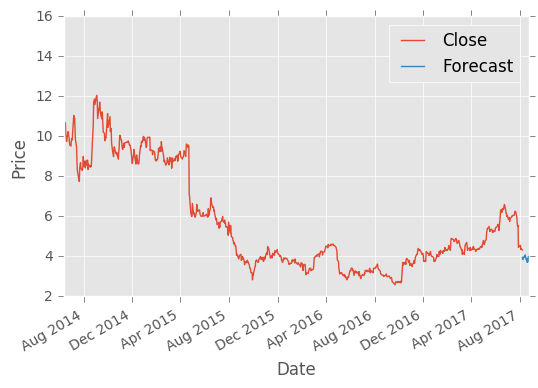

In [21]:
df['Close'].plot()
df['Forecast'].plot()
plt.legend(loc=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

This is a very basic predictor. For a slightly advanced predictor doing sentiment analysis and using advanced ML model take a look at : 

https://github.com/llSourcell/Stock_Market_Prediction

If you want to go really deep, check these out :

* https://www.quantopian.com/
* https://numer.ai/

